In [9]:
from keras.preprocessing.image import load_img
from skimage.feature import hog
from skimage import data, exposure
from scipy.spatial import distance

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [10]:
## create list of image files

# enter paths to all directories from which you want to cluster images
preprocessed_imgs = "/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/multi"
paths = [x[0] for x in os.walk(preprocessed_imgs) if x[0] != preprocessed_imgs and not os.path.basename(x[0]).startswith('.')]
#paths = ["/home/tschernn/becore-clustering/images"]
# change the working directory to the path where the images are located

# this list holds all the image filenames
charters = []

# iterate over files in path
for path in paths:
    with os.scandir(path) as files:
        for file in files:
            if file.name.endswith(('.png', '.jpg')):
              # adds the image files to the list
                charters.append((file.name, path.split('/')[-1]))

# save list of charters and folders
charter_p = r"/home/tschernn/becore-clustering/charter_list.pkl"

with open(charter_p,'wb') as file:
    pickle.dump(charters, file)

charters[0:-1:50]

[('wa_62f113115f5d2e4ead5b5c9e256bbe1e2.jpg', 'writable_area_notar_fr'),
 ('wa_00a79df1d8a2493ebaf432cde61277f9.jpg', 'writable_area_sonstige_fr'),
 ('wa_721b7f144ef5a62c5a4aafbf2f74b546.jpg', 'writable_area_notar_oe'),
 ('wa_7c60e4a73e04966b18d37f55348766b3.jpg', 'writable_area_sonstige_oe'),
 ('wa_b73fa9d81858407ac0d6bab2d709028c.jpg', 'writable_area_papst_oe'),
 ('wa_4ea68cfd4e67ab45fb8d053343691e79.jpg', 'writable_area_papst_fr'),
 ('wa_711d39383af2fd41275a8b3a74312a8b.jpg', 'writable_area_papst_fr')]

In [11]:
## reshape imgs

img_size = (1024, 768)

def reshape_img(file):
    # load the image as a PIL of the chosen size
    img = load_img(file, target_size=img_size)
    # convert from 'PIL.Image.Image' to numpy array => img.shape is e.g. (224, 224, 3)
    img = np.array(img)
    # reshape the array for the model - reshape(num_of_samples, dim 1, dim 2, channels) => img.shape is e.g. (1, 224, 224, 3)
    reshaped_img = img.reshape(1, img_size[0], img_size[1], 3)
    return reshaped_img

### save and export image array
 
imgs_list = []
for charter in charters:
    reshaped = reshape_img(f'{preprocessed_imgs}/{charter[1]}/{charter[0]}')
    #reshaped = reshape_img('/home/tschernn/becore-clustering/images/illurk.jpg')
    imgs_list.append(reshaped)
imgs_array = np.array(imgs_list)
imgs_array = imgs_array.squeeze(axis=1)

p = r"/home/tschernn/becore-clustering/img_array.pkl"

with open(p,'wb') as file:
    pickle.dump(imgs_array, file)
    print(f'Saved image arrays as {file.name}.')

Saved image arrays as /home/tschernn/becore-clustering/img_array.pkl.


In [12]:
def extract_features_hog(image):
    feat, hog_image = hog(image, orientations=9, 
                        pixels_per_cell=(16, 16), cells_per_block=(4, 4), 
                        visualize=True, channel_axis=-1)
    return feat, hog_image

In [13]:
feature_list = []
hog_image_list = []

len_imgs = len(imgs_array)

for i in range(len_imgs):
    feature, hog_image = extract_features_hog(imgs_array[i])    
    feature_list.append(feature)
    hog_image_list.append(hog_image)

In [14]:
# create an empty nxn distance matrix
distance_matrix = np.zeros((len_imgs, len_imgs))

for i in range(len_imgs):
    fd_i = feature_list[i]
    for k in range(i):
        fd_k = feature_list[k]
        # measure Jensen–Shannon distance between each feature vector and add to the distance matrix
        distance_matrix[i, k] = distance.jensenshannon(fd_i, fd_k)

# symmetrize the matrix as distance matrix is symmetric
distance_matrix = np.maximum(distance_matrix, distance_matrix.transpose())
data = distance_matrix

data.shape

(304, 304)

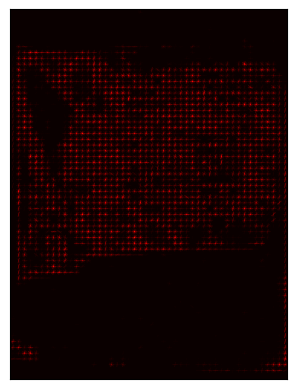

In [15]:
## visualize HOG image
fig = plt.imshow(hog_image_list[0])
fig.set_cmap('hot')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('hog.jpg', bbox_inches='tight', pad_inches=0, dpi=500)
plt.show()

In [16]:
### export data as pickle file

p = r"/home/tschernn/becore-clustering/features_hog.pkl"

with open(p,'wb') as file:
    pickle.dump(distance_matrix, file)
    print(f'Saved features as {file.name}.')

Saved features as /home/tschernn/becore-clustering/features_hog.pkl.
